# Analysis of transaction diffusion in memory pool

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

## Parameters

In [2]:
k <- 20
N <- 30000

## Extent of diffusion

### Mean number of hops

In [3]:
logb(N, k)

[1] 3.441213

### Standard devision of number of hops

In [4]:
pi / log(k) / sqrt(3)

[1] 0.6054611

### Recursion relation

In [5]:
hHi <- function(i) {
    if (i <= 0)
        list(h=1, H=1)
    else {
        prev <- hHi(i - 1)
        k1 <- k * (N - 2) / (N - 1)
        h <- (N - prev$H) * (1 - (1 - 1 / N)^(prev$h * k1))
        H <- prev$H + h
        list(h=h, H=H)
    }
}

Mean

In [6]:
mapply(function(i) i / N * hHi(i)$h, 0:10) %>% sum

[1] 3.74988

Diffusion at three or four hops.

In [7]:
hHi(3)$H / N

[1] 0.24318

In [8]:
hHi(4)$H / N

[1] 0.992277

### Approximation

In [9]:
Hest <- function(i)
    N / (1 + (N / 1 - 1) / (k - 1)^i)

### Comparision of methods

In [10]:
example <- CJ(i=0:7)[
    ,
    .(`Number of hops`=`i`, `Recursion`=mapply(function(i) hHi(i)$H,`i`), `Logistic`=mapply(Hest,`i`))
]
example

Number of hops,Recursion,Logistic
<int>,<dbl>,<dbl>
0,1.00000,1.00000
1,20.99234,18.98861
2,417.90171,356.71937
3,7295.39990,5582.77714
4,29768.30996,24386.41467
5,29999.99993,29640.88795
6,29999.99994,29980.88257
7,29999.99994,29998.99321


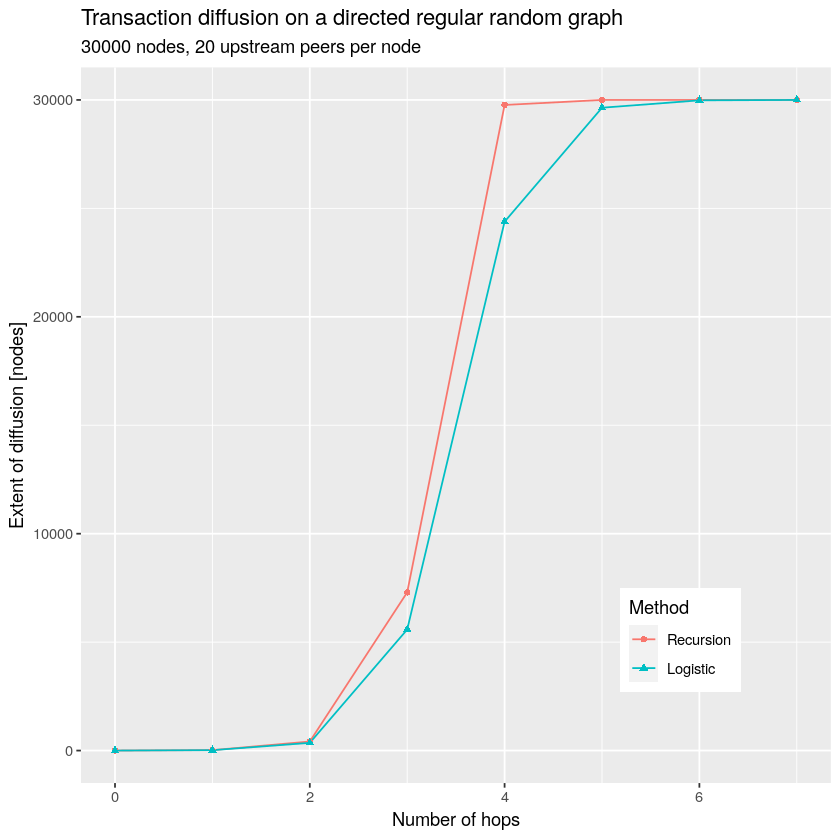

In [11]:
ggplot(
    melt(example, id.vars="Number of hops", variable.name="Method", value.name="Extent of diffusion [nodes]"),
    aes(x=`Number of hops`, y=`Extent of diffusion [nodes]`, color=`Method`, shape=`Method`)
) +
    geom_line() +
    geom_point() +
    ggtitle(
        "Transaction diffusion on a directed regular random graph",
        paste(N, "nodes,", k, "upstream peers per node")
    ) +
    theme(legend.position=c(0.8, 0.2))

In [12]:
ggsave("diffusion.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("diffusion.svg", units="in", dpi=150, width=8, height=6)

## Mempool fragmentation

In [14]:
fragmentation <- fread("../mempool-sim-web/experiment/tmp/fragmentation.tsv.gz", stringsAsFactors=TRUE)
fragmentation %>% summary

     Trial           Time [s]         Node ID               TxId          
 Min.   : 0.000   Min.   :  0.00   H102   :    13082   T305   :   453143  
 1st Qu.: 5.000   1st Qu.: 27.00   H2256  :    13082   T28    :   451584  
 Median :10.000   Median : 65.00   H2544  :    13082   T188   :   447535  
 Mean   : 9.844   Mean   : 63.85   H3831  :    13082   T261   :   436900  
 3rd Qu.:15.000   3rd Qu.: 95.00   H4651  :    13082   T48    :   435451  
 Max.   :20.000   Max.   :148.00   H5179  :    13082   T106   :   434822  
                                   (Other):130714882   (Other):128133939  

In [15]:
abstract <- melt(
    fragmentation[
        , 
        .(`Nodes`=.N), 
        .(`Trial`, `Time [s]`, `TxId`)
    ][
        ,
        .(
            `Minimum (exp't)`=min(`Nodes`)%>%as.numeric,
            `Mean (exp't)`=mean(`Nodes`),
            `Txs`=length(unique(`TxId`))
        ),
        .(`Trial`, `Time [s]`)
    ],
    id.vars=c("Trial", "Time [s]", "Txs"),
    variable.name="Statistic",
    value.name="Number of nodes with tx in mempool"
)

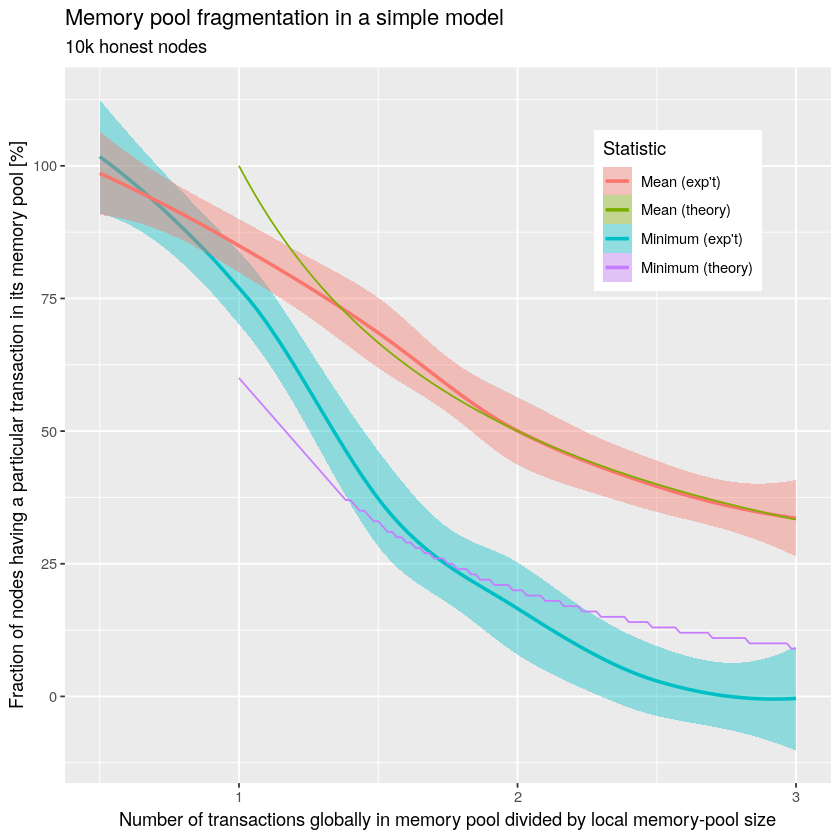

In [16]:
ggplot(
    abstract,
    aes(x=`Txs`/120, y=`Number of nodes with tx in mempool`/100, color=`Statistic`, fill=`Statistic`)
) +
    geom_smooth(formula=y~x, method="loess") +
    geom_line(
        data=data.table(x=100:300/100, y=100/(100:300/100), `Statistic`="Mean (theory)"),
        aes(x=`x`, y=`y`)
    ) +
    geom_line(
        data=data.table(x=60:180/60, y=mapply(function(xi) qhyper(1/10001, 60, 60 * xi - 60, 60), 60:180/60), `Statistic`="Minimum (theory)"),
        aes(x=`x`, y=`y`)
    ) +
    scale_y_continuous(breaks=c(0, 25, 50, 75, 100)) +
    xlab("Number of transactions globally in memory pool divided by local memory-pool size") +
    ylab("Fraction of nodes having a particular transaction in its memory pool [%]") +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    ) +
    theme(legend.position=c(0.8,0.8))

In [17]:
ggsave("fragmentation-load-loess-theory.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("fragmentation-load-loess-theory.svg", units="in", dpi=150, width=8, height=6)